# T-SNE + K-Means method

Loading data...
Original data shape: (60000, 1, 28, 28)
Reshaped data shape: (60000, 784)
Reduced data shape (10% of original): (60000, 784)
Data scaled.
Training set: (48000, 784), Test set: (12000, 784)

=== Running t-SNE + K-means Pipeline ===
Running t-SNE + K-means pipeline...
Running t-SNE dimensionality reduction...


c:\Users\rmkp\Documents\IITB\PML - Project\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE transformed data shape: (48000, 2)
Running K-means clustering...
t-SNE + K-means silhouette score: 0.3909
Creating PCA model for test set predictions...
Function tsne_kmeans_pipeline executed in 141.7299 seconds

Total execution time: 141.7299 seconds
Silhouette score: 0.3909

Cluster distribution:
Cluster 0: 3895 samples
Cluster 1: 5070 samples
Cluster 2: 4791 samples
Cluster 3: 4746 samples
Cluster 4: 4535 samples
Cluster 5: 4426 samples
Cluster 6: 5955 samples
Cluster 7: 5008 samples
Cluster 8: 5117 samples
Cluster 9: 4457 samples


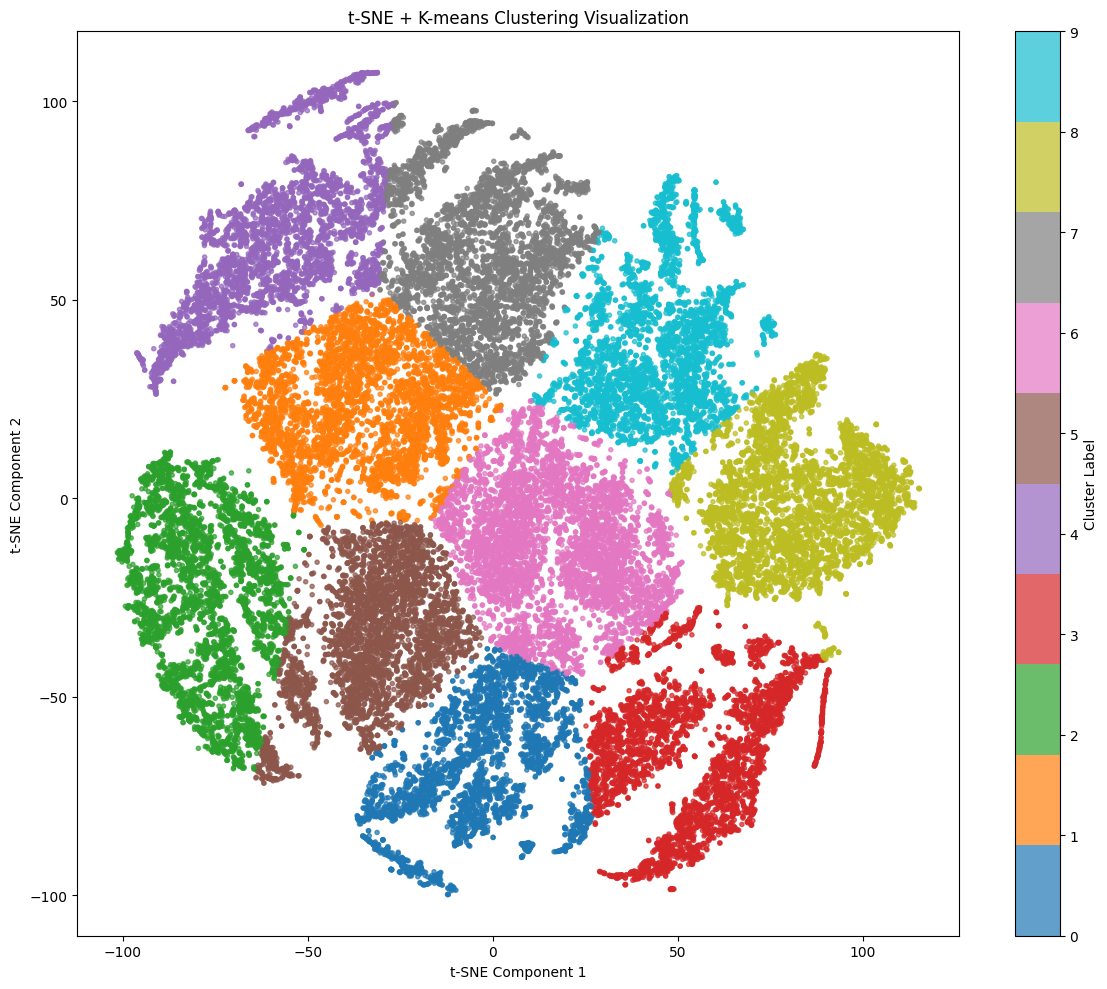

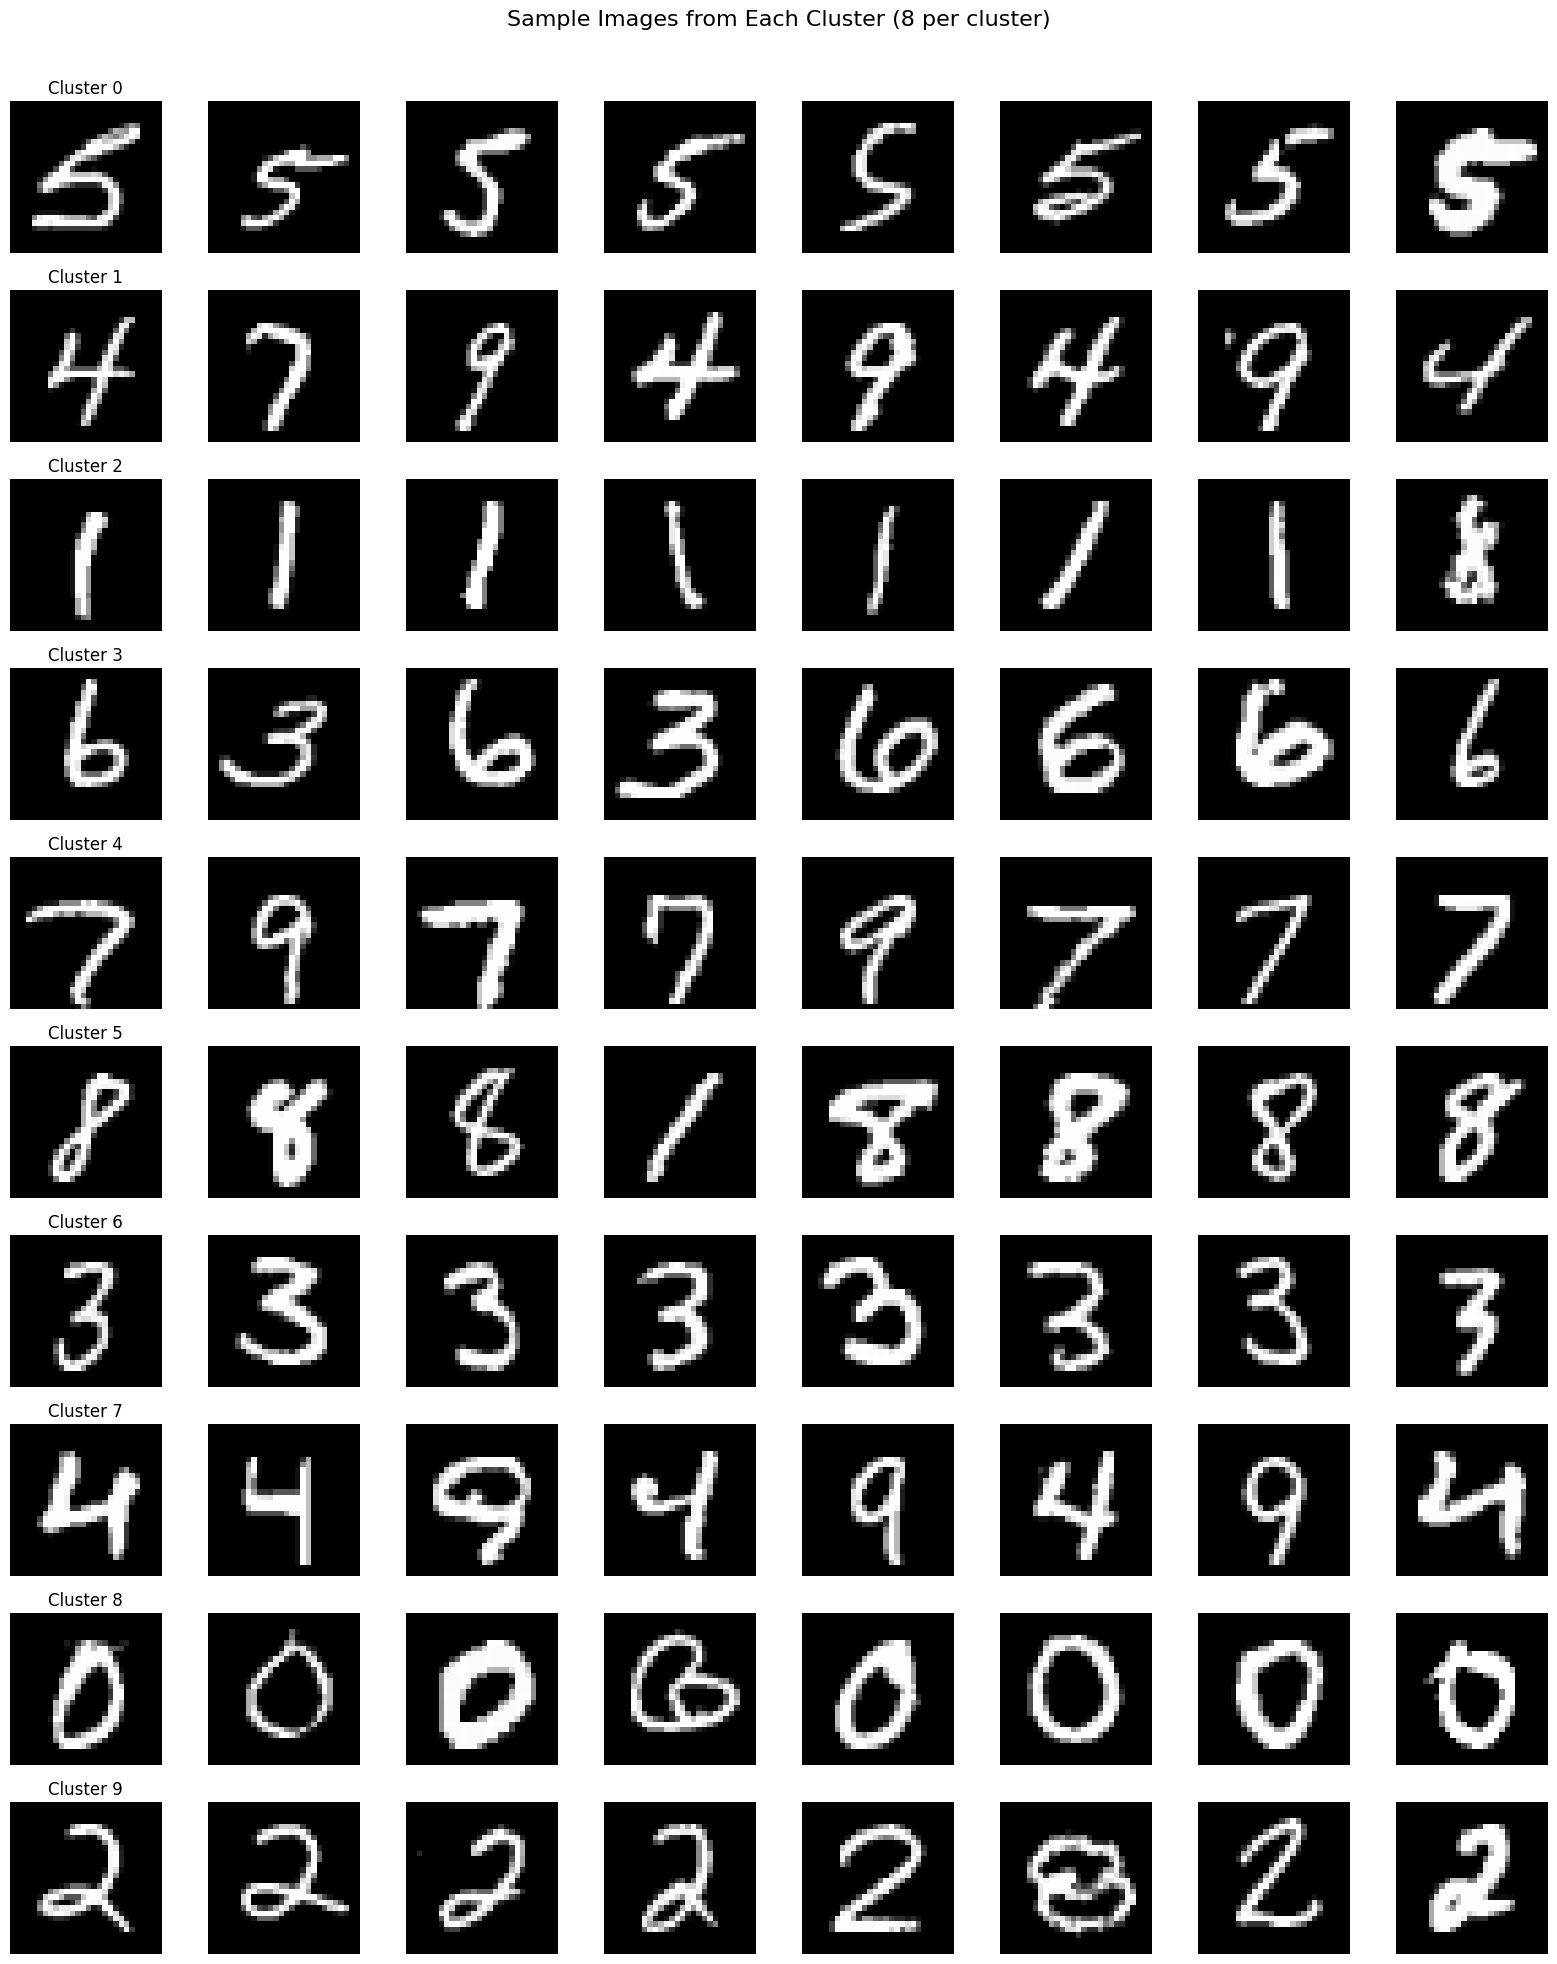


========== t-SNE + K-MEANS CLUSTERING REPORT ==========
Silhouette score: 0.3909

Class distribution:
Cluster 0: 3895 samples (8.1%)
Cluster 1: 5070 samples (10.6%)
Cluster 2: 4791 samples (10.0%)
Cluster 3: 4746 samples (9.9%)
Cluster 4: 4535 samples (9.4%)
Cluster 5: 4426 samples (9.2%)
Cluster 6: 5955 samples (12.4%)
Cluster 7: 5008 samples (10.4%)
Cluster 8: 5117 samples (10.7%)
Cluster 9: 4457 samples (9.3%)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Timer function for performance tracking
def timer_func(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"Function {func.__name__} executed in {end_time-start_time:.4f} seconds")
        return result, end_time-start_time
    return wrapper

# Load data
print("Loading data...")
file_path = "unlabelled_train_data_images.npy"
data = np.load(file_path, allow_pickle=True)
print(f"Original data shape: {data.shape}")

# Reshape data for processing
reshaped_data = data.reshape(data.shape[0], -1)
print(f"Reshaped data shape: {reshaped_data.shape}")

# Take only 10% of the data for faster processing
sample_size = int(reshaped_data.shape[0] * 1)
indices = np.random.choice(reshaped_data.shape[0], size=sample_size, replace=False)
reduced_data = reshaped_data[indices]
reduced_original_data = data[indices]
print(f"Reduced data shape (10% of original): {reduced_data.shape}")

# Preprocessing
scaler = StandardScaler()
scaled_data = scaler.fit_transform(reduced_data)
print("Data scaled.")

# Create train/test split
X_train, X_test, original_train_indices, original_test_indices = train_test_split(
    scaled_data, indices, test_size=0.2, random_state=42)
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

# Focused t-SNE + K-means pipeline
@timer_func
def tsne_kmeans_pipeline(X_train, X_test, original_data, n_clusters=10):
    print("Running t-SNE + K-means pipeline...")
    
    # Apply t-SNE for dimensionality reduction
    print("Running t-SNE dimensionality reduction...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    X_train_tsne = tsne.fit_transform(X_train)
    print(f"t-SNE transformed data shape: {X_train_tsne.shape}")
    
    # Apply K-means clustering
    print("Running K-means clustering...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_train_tsne)
    
    # Calculate silhouette score for clustering quality
    score = silhouette_score(X_train_tsne, cluster_labels)
    print(f"t-SNE + K-means silhouette score: {score:.4f}")
    
    # For test set predictions, we need a classifier since t-SNE doesn't generalize to new data points
    # Instead, we'll use PCA for the test set as a practical approach
    print("Creating PCA model for test set predictions...")
    pca = PCA(n_components=50, random_state=42)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    return {
        "X_train_tsne": X_train_tsne,
        "clusters": cluster_labels,
        "X_train_pca": X_train_pca,
        "X_test_pca": X_test_pca,
        "score": score,
        "kmeans": kmeans,
        "pca": pca
    }

# Run the t-SNE + K-means pipeline
print("\n=== Running t-SNE + K-means Pipeline ===")
results, execution_time = tsne_kmeans_pipeline(X_train, X_test, reduced_original_data)

print(f"\nTotal execution time: {execution_time:.4f} seconds")
print(f"Silhouette score: {results['score']:.4f}")

# Print cluster distribution
print("\nCluster distribution:")
unique, counts = np.unique(results['clusters'], return_counts=True)
for i, (cluster, count) in enumerate(zip(unique, counts)):
    print(f"Cluster {cluster}: {count} samples")

# Visualize clusters in 2D space
plt.figure(figsize=(12, 10))
plt.scatter(results['X_train_tsne'][:, 0], results['X_train_tsne'][:, 1], 
            c=results['clusters'], cmap='tab10', marker='.', alpha=0.7)
plt.colorbar(label='Cluster Label')
plt.title('t-SNE + K-means Clustering Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.tight_layout()
plt.show()

# Visualize 8 images from each cluster
n_clusters = len(np.unique(results['clusters']))
fig = plt.figure(figsize=(16, 2*n_clusters))
fig.suptitle('Sample Images from Each Cluster (8 per cluster)', fontsize=16)

for i in range(n_clusters):
    # Get indices of samples in this cluster
    cluster_indices = np.where(results['clusters'] == i)[0]
    
    # Select 8 random samples (or fewer if the cluster has less than 8)
    sample_size = min(8, len(cluster_indices))
    if sample_size > 0:
        sample_indices = np.random.choice(cluster_indices, sample_size, replace=False)
        
        # Display images
        for j, idx in enumerate(sample_indices):
            plt.subplot(n_clusters, 8, i*8 + j + 1)
            
            # Map from training indices to original data indices
            original_idx = original_train_indices[idx]
            
            # Display the image
            plt.imshow(np.squeeze(data[original_idx]), cmap='gray')
            plt.axis('off')
            if j == 0:
                plt.title(f'Cluster {i}')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# Output the comprehensive report 4
print("\n========== t-SNE + K-MEANS CLUSTERING REPORT ==========")
print(f"Silhouette score: {results['score']:.4f}")
print("\nClass distribution:")
for i, (cluster, count) in enumerate(zip(unique, counts)):
    print(f"Cluster {cluster}: {count} samples ({count/len(results['clusters'])*100:.1f}%)")